In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

Exploring the number of beers per country
Exploring the number of user per country
number of reviews per country

BeerAdvocate exploration

In [ ]:
#number of beers per country
breweries = pd.read_csv('../../minimizedData/BA_breweries_small.csv')
breweries.head(2)


   Unnamed: 0     id    location                    name  nbr_beers
0           0  39912  Kyrgyzstan  Abdysh-Ata (Абдыш Ата)          5
1           1  39913  Kyrgyzstan             Arpa (АРПА)          1
2           2  39914  Kyrgyzstan               Bear Beer          4
3           3  39915  Kyrgyzstan             Blonder Pub          4
4           4  39916  Kyrgyzstan            Kellers Bier          2


In [ ]:
# Group by country (location) and calculate total number of breweries and beers
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),  
    total_beers=('nbr_beers', 'sum')  
).reset_index()

filtered_countries = country_stats[country_stats['total_beers'] >= 4]

print("there are a total of 297 locations")
print("229 locations have 4 or more beers")
#Do what countries do we automatically remove for our analysis since they don't have enough beers to analyse
#How much do we want to remove

(297, 3)
(229, 3)
there are a total of 297 locations
229 locations have 4 or more beers


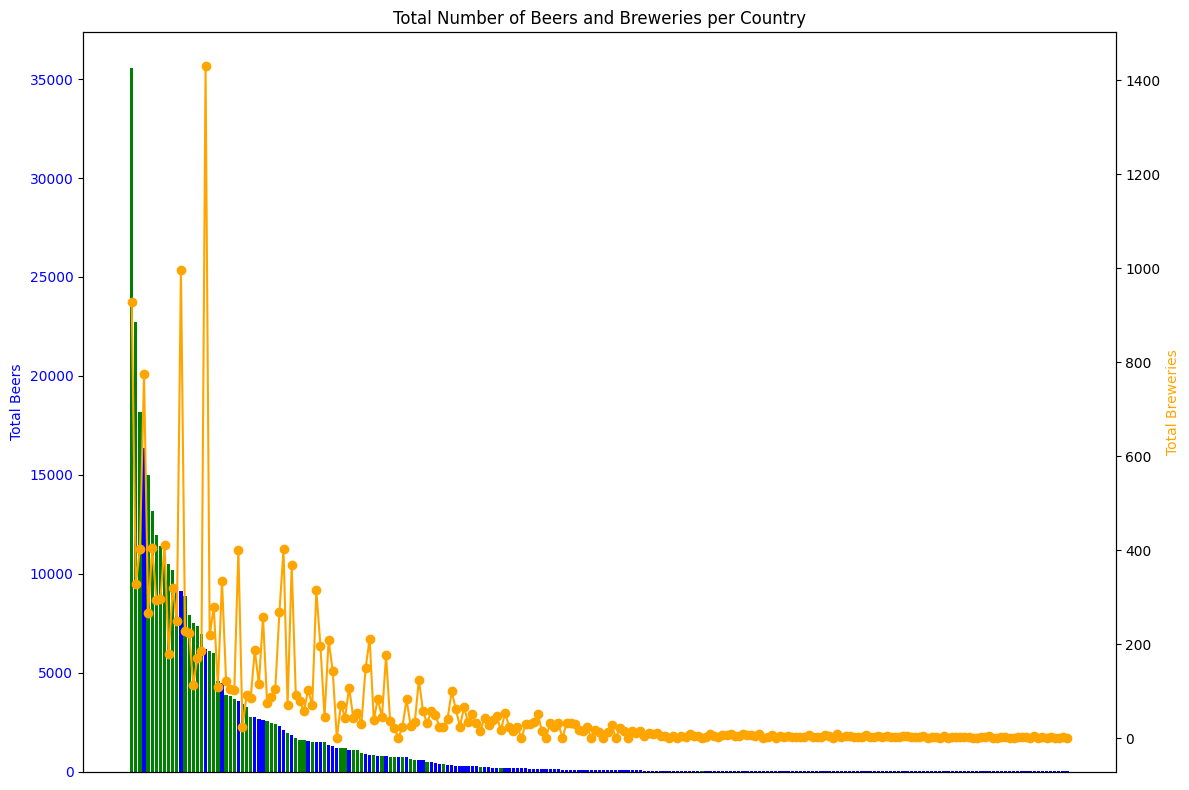

I think looking at the US would be more interesting than anything else


In [ ]:
# Plotting the total number of beers and breweries for each country
filtered_countries = filtered_countries.sort_values(by='total_beers', ascending=False)
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_colors = ['green' if country.startswith('United States,') else 'blue' for country in filtered_countries['location']]

# Bar plot for total beers
ax1.bar(filtered_countries['location'], filtered_countries['total_beers'], color=bar_colors, label='Total Beers')
#ax1.set_xlabel('Country')
ax1.set_ylabel('Total Beers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks([])

# Overlay line plot for total breweries
ax2 = ax1.twinx()
ax2.plot(filtered_countries['location'], filtered_countries['total_breweries'], color='orange', marker='o', label='Total Breweries')
ax2.set_ylabel('Total Breweries', color='orange')
plt.xticks([])

# Adding title and showing legend
plt.title('Total Number of Beers and Breweries per Country')
fig.tight_layout()
plt.show()

print("I think looking at the US would be more interesting than anything else")

In [ ]:
users = pd.read_csv('../../minimizedData/BA_users_small.csv')
print("total number of users:", users.shape[0])
#remove users with unknown locations
users = users.dropna(subset=['location'])
print("Number of users with known locations:", users.shape[0])
print("Users originate from: ", users['location'].nunique() , "different locations")

total number of users: 153704
Number of users with known locations: 122425
Users originate from:  194 different locations


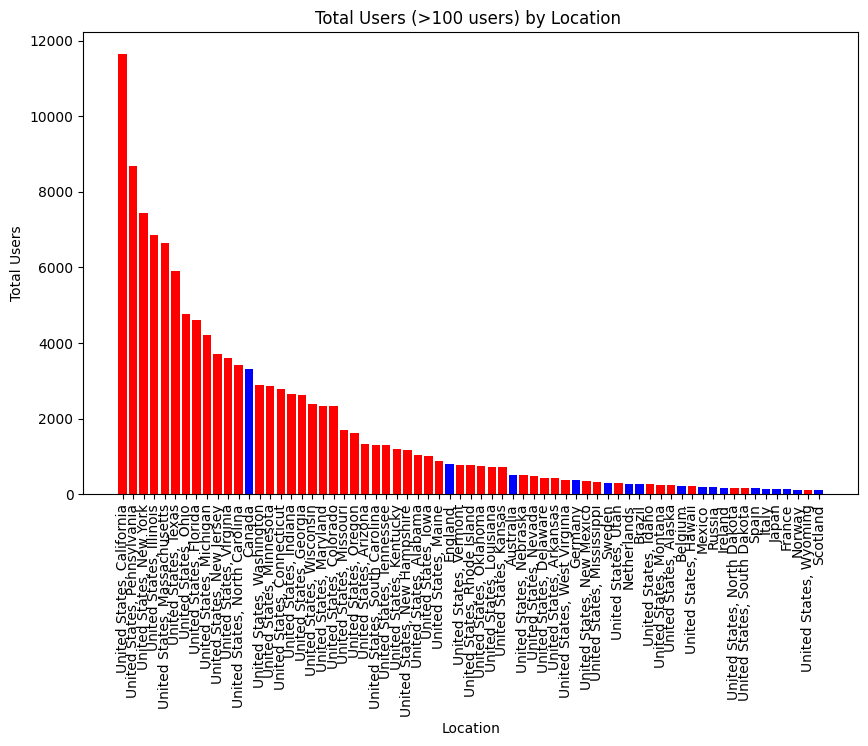

In [ ]:
user_counts = users.groupby('location').size().reset_index(name='total_users')
user_counts = user_counts[user_counts['total_users'] >= 100]
user_counts = user_counts.sort_values(by='total_users', ascending=False)
user_counts['color'] = user_counts['location'].apply(lambda x: 'red' if x.startswith('United States,') else 'blue')

plt.figure(figsize=(10, 6))
plt.bar(user_counts['location'], user_counts['total_users'], color=user_counts['color'])
plt.xlabel('Location')
plt.ylabel('Total Users')
plt.title('Total Users (>100 users) by Location ')
plt.xticks(rotation=90)
#plt.xticks([])
plt.show()

In [ ]:
us_users = users[users['location'].str.startswith('United States,')]
#Group by location and count the number of users
us_user_counts = us_users.groupby('location').size().reset_index(name='total_users')

#Sort the DataFrame by the total number of users
us_user_counts = us_user_counts.sort_values(by='total_users', ascending=False)

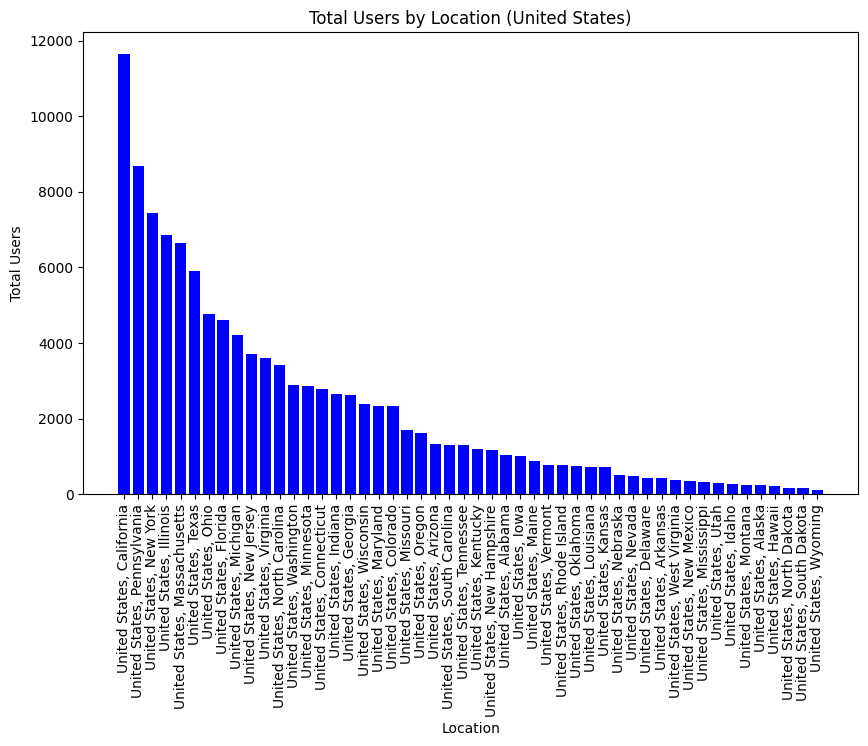

In [8]:
#Plotting US users distribution
plt.figure(figsize=(10, 6))
plt.bar(us_user_counts['location'], us_user_counts['total_users'], color='blue')
plt.xlabel('Location')
plt.ylabel('Total Users')
plt.title('Total Users by Location (United States)')
plt.xticks(rotation=90)
plt.show()

In [9]:
#plot reviews FOR a country

#plot reviews FROM a country
ratings = pd.read_csv('../../minimizedData/BA_ratings_small.csv')
brewery = pd.read_csv('../../minimizedData/BA_breweries_small.csv')
BA_merged = pd.read_csv('../../minimizedData/Modified/BA_ratbeer.csv')
print(BA_merged.head())




FileNotFoundError: [Errno 2] No such file or directory: '../../minimizedData/Modified/BA_ratbeer.csv'

C:\Users\iaran\AppData\Local\Temp\ipykernel_7816\163118670.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout to prevent label cutoff


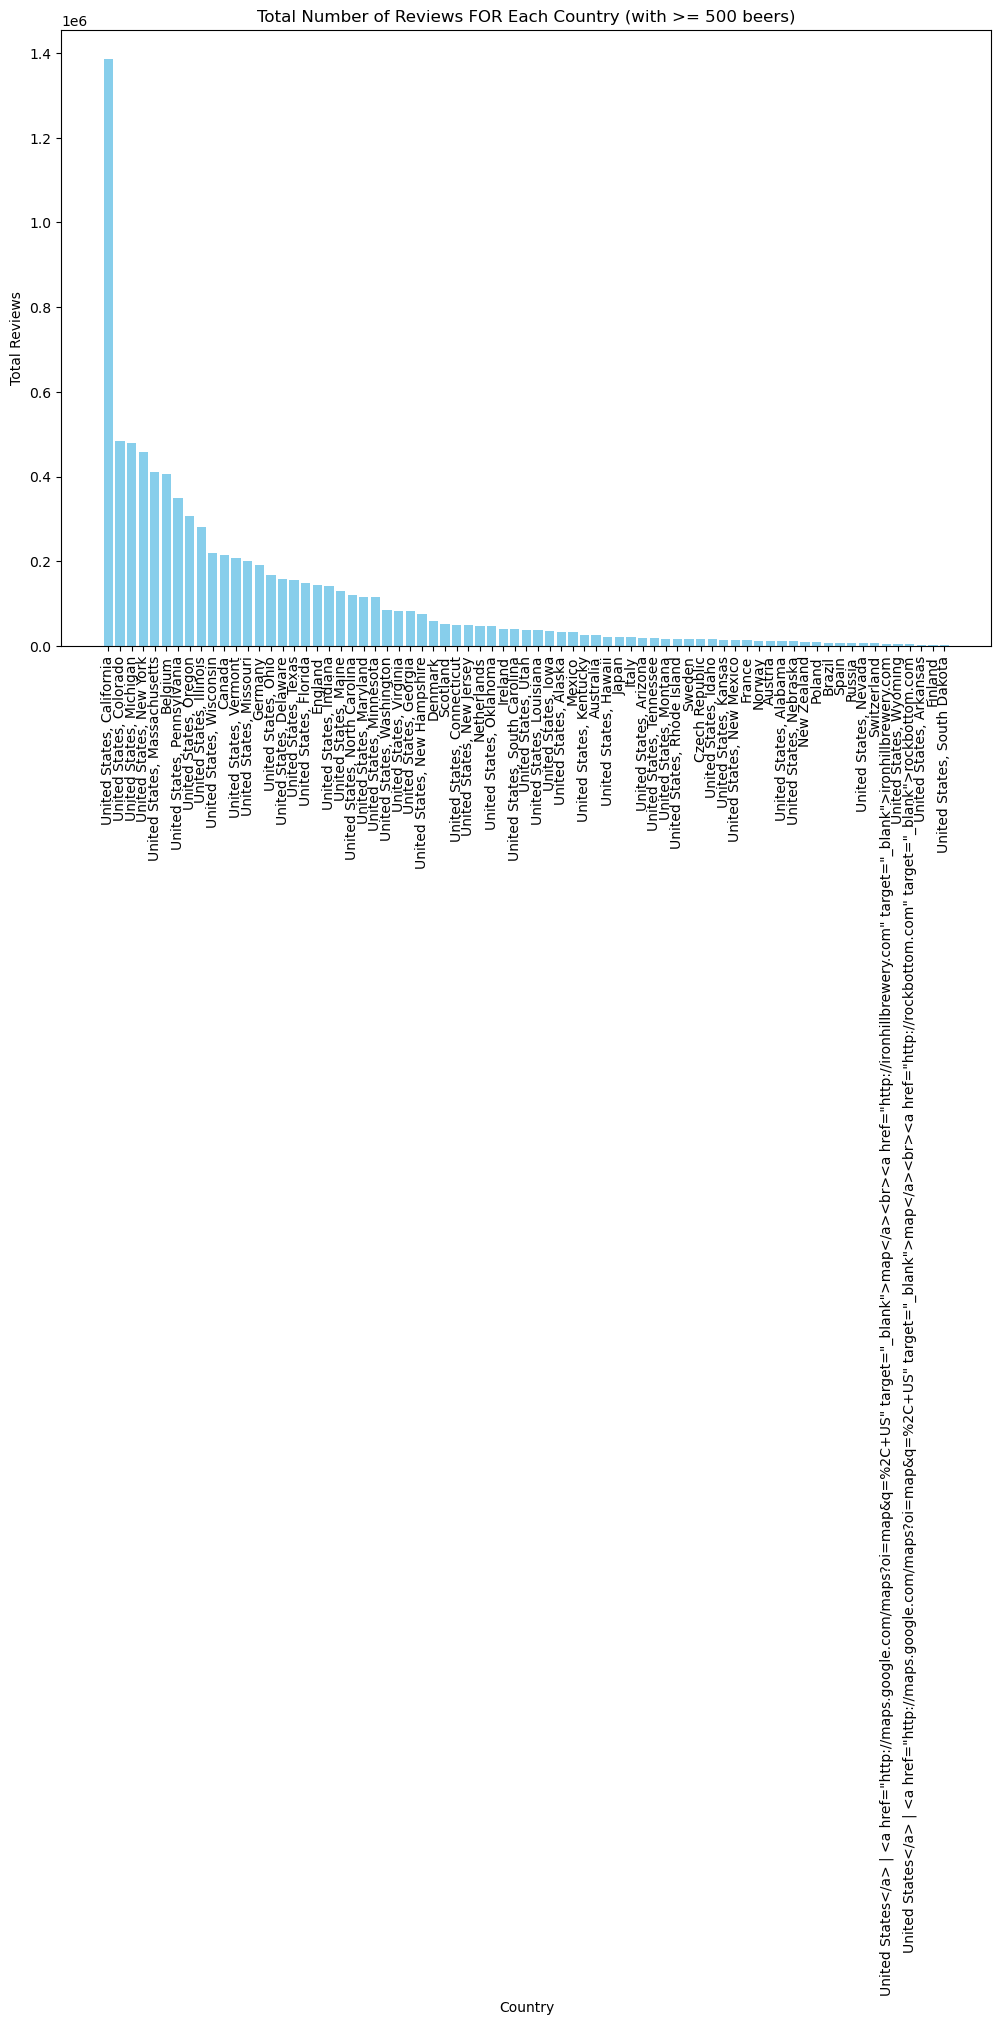

In [ ]:
# Step 1: Remove breweries with no location
breweries = breweries[breweries['location'].notna()]

# Step 2: Group by country (location) and count the number of reviews
country_review_counts = ratings_with_location.groupby('location').size().reset_index(name='total_reviews')

# Step 3: Count the number of beers per country from the breweries DataFrame
beer_counts = breweries.groupby('location')['nbr_beers'].sum().reset_index(name='total_beers')

# Step 4: Merge the beer counts with the review counts
country_review_counts = pd.merge(country_review_counts, beer_counts, on='location', how='left')

# Step 5: Filter out countries with less than 500 beers
country_review_counts = country_review_counts[country_review_counts['total_beers'] >= 500]

# Step 6: Sort the DataFrame by total number of reviews in descending order
country_review_counts = country_review_counts.sort_values(by='total_reviews', ascending=False)

# Step 7: Plot the result
plt.figure(figsize=(12, 8))
plt.bar(country_review_counts['location'], country_review_counts['total_reviews'], color='skyblue')

# Optional: Add labels and title
plt.xlabel('Country')
plt.ylabel('Total Reviews')
plt.title('Total Number of Reviews FOR Each Country (with >= 500 beers)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()


In [ ]:
ratings_with_user_location = pd.merge(ratings, users[['user_id', 'location']], on='user_id', how='left')

# Step 2: Rename the location column to 'user_location' in the merged DataFrame
ratings_with_user_location.rename(columns={'location': 'user_location'}, inplace=True)

# Display the updated DataFrame with the new column 'user_location'
ratings_with_user_location.head()

,Unnamed: 0,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,user_location
0,0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"United States, Washington"
1,1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,"United States, New York"
2,2,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,Northern Ireland
3,3,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Northern Ireland
4,4,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,Northern Ireland


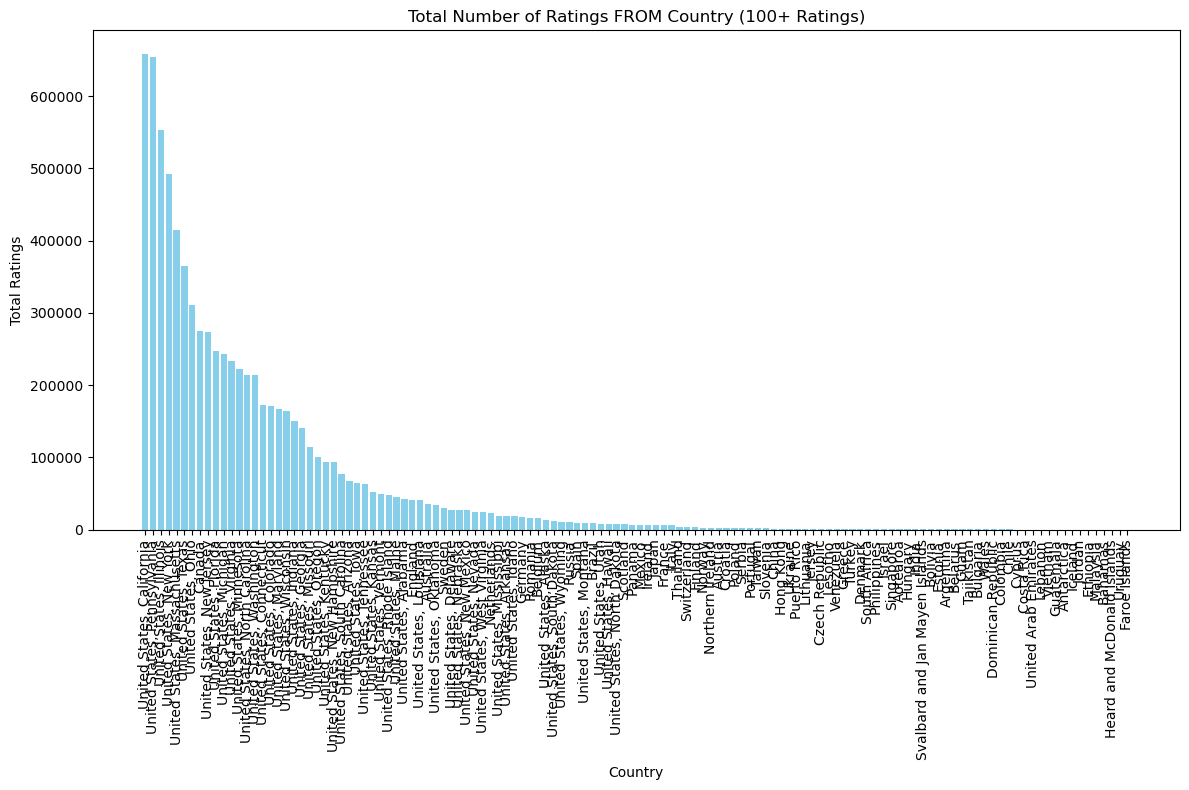

In [ ]:
# Step 1: Group by 'user_location' (country) and count the total number of ratings for each country
country_rating_counts = ratings_with_user_location.groupby('user_location').size().reset_index(name='total_ratings')

# Step 2: Filter out countries with less than 100 ratings
country_rating_counts = country_rating_counts[country_rating_counts['total_ratings'] >= 100]

# Step 3: Sort the DataFrame by total number of ratings in descending order
country_rating_counts = country_rating_counts.sort_values(by='total_ratings', ascending=False)

# Step 4: Plot the result
plt.figure(figsize=(12, 8))
plt.bar(country_rating_counts['user_location'], country_rating_counts['total_ratings'], color='skyblue')

# Optional: Add labels and title
plt.xlabel('Country')
plt.ylabel('Total Ratings')
plt.title('Total Number of Ratings FROM Country (100+ Ratings)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()


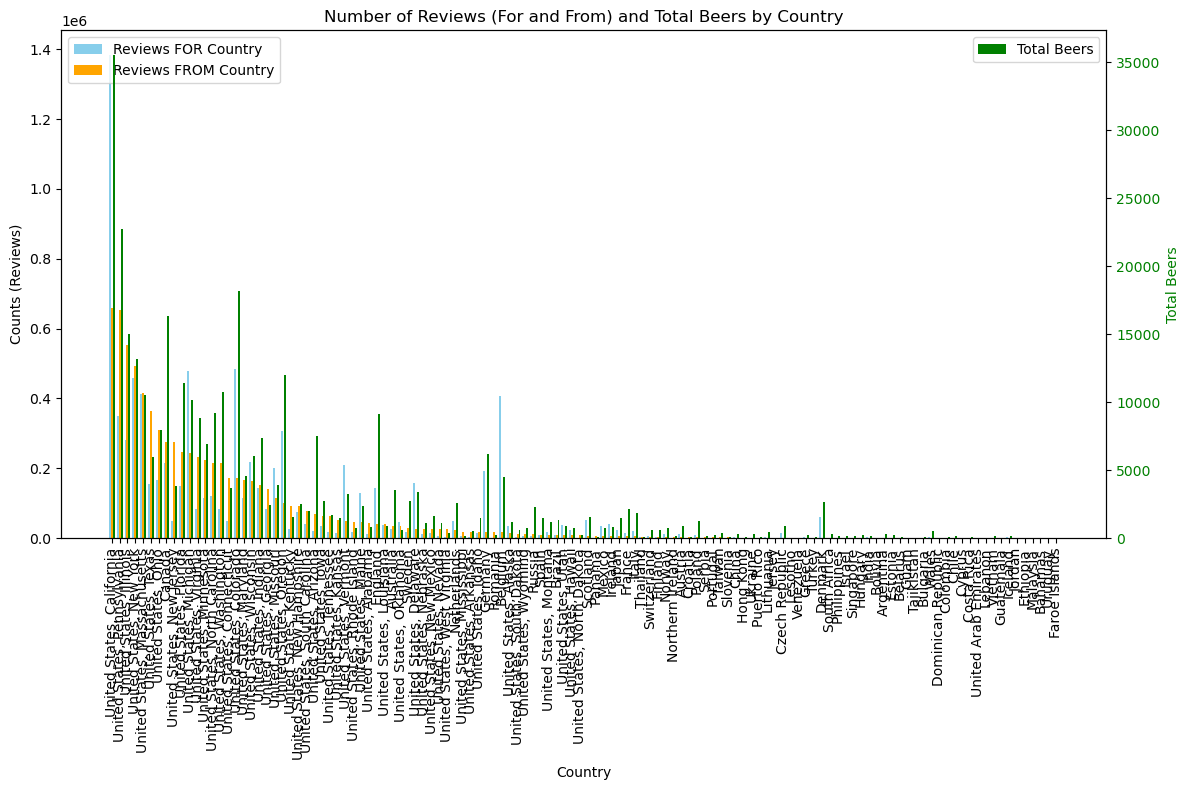

In [ ]:
# Step 1: Group by country (location) and count the number of reviews for that country (total reviews for the country)
country_review_for = ratings_with_location.groupby('location').size().reset_index(name='total_reviews_for')

# Step 2: Group by user_location and count the number of reviews made by users from that country
country_review_from = ratings_with_user_location.groupby('user_location').size().reset_index(name='total_reviews_from')

# Step 3: Group by country (location) and sum the number of beers from the breweries DataFrame
beer_counts = breweries.groupby('location')['nbr_beers'].sum().reset_index(name='total_beers')

# Step 4: Merge the dataframes into one
country_data = pd.merge(country_review_for, country_review_from, left_on='location', right_on='user_location', how='left')
country_data = pd.merge(country_data, beer_counts, on='location', how='left')

# Step 5: Filter countries with less than 100 reviews (optional)
country_data = country_data[country_data['total_reviews_from'] >= 100]

# Step 6: Sort the DataFrame by total_reviews_from in ascending order
country_data = country_data.sort_values(by='total_reviews_from', ascending=False)

# Step 7: Create the figure and the primary axis (for reviews)
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.25
index = range(len(country_data))

# Plot the bars for the 3 different metrics on the primary y-axis
bar1 = ax1.bar(index, country_data['total_reviews_for'], bar_width, label='Reviews FOR Country', color='skyblue')
bar2 = ax1.bar([i + bar_width for i in index], country_data['total_reviews_from'], bar_width, label='Reviews FROM Country', color='orange')

# Set labels and title for the primary axis
ax1.set_xlabel('Country')
ax1.set_ylabel('Counts (Reviews)', color='black')
ax1.set_title('Number of Reviews (For and From) and Total Beers by Country')

# Set x-ticks and labels
ax1.set_xticks([i + bar_width for i in index])  # Set x-ticks in the center of the 3 bars
ax1.set_xticklabels(country_data['location'], rotation=90)
ax1.tick_params(axis='y', labelcolor='black')

# Step 8: Create the secondary axis (for the total number of beers)
ax2 = ax1.twinx()  # Create a second y-axis
bar3 = ax2.bar([i + 2 * bar_width for i in index], country_data['total_beers'], bar_width, label='Total Beers', color='green')

# Set labels for the secondary axis (right y-axis)
ax2.set_ylabel('Total Beers', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Step 9: Adjust layout and add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout for readability
plt.tight_layout()

# Step 10: Show the plot
plt.show()


In [ ]:
# Step 1: Group by 'location' (beer location) and count the number of reviews for that country (total reviews FOR country)
country_review_for = ratings_with_location.groupby('location').size().reset_index(name='total_reviews_for')

# Step 2: Group by 'user_location' (user's location) and count the number of reviews made by users from that country
reviews_from_own_location = ratings_with_user_location[ratings_with_user_location['user_location'] == ratings_with_user_location['location']]
country_review_from_own = reviews_from_own_location.groupby('user_location').size().reset_index(name='total_reviews_from_own')

# Step 3: Group by 'location' (beer location) and count the reviews from other countries (exclude own country)
reviews_from_other_locations = ratings_with_user_location[ratings_with_user_location['user_location'] != ratings_with_user_location['location']]
country_review_from_other = reviews_from_other_locations.groupby('user_location').size().reset_index(name='total_reviews_from_other')

# Step 4: Group by country (location) and sum the number of beers from the breweries DataFrame
beer_counts = breweries.groupby('location')['nbr_beers'].sum().reset_index(name='total_beers')

# Step 5: Merge the dataframes into one
country_data = pd.merge(country_review_for, country_review_from_own, left_on='location', right_on='user_location', how='left')
country_data = pd.merge(country_data, country_review_from_other, on='location', how='left')
country_data = pd.merge(country_data, beer_counts, on='location', how='left')

# Step 6: Filter countries with less than 100 reviews (optional)
country_data = country_data[country_data['total_reviews_from_own'] >= 100]

# Step 7: Sort the DataFrame by the total number of reviews from users from other locations in ascending order
country_data = country_data.sort_values(by='total_reviews_from_other', ascending=False)

# Step 8: Create the figure and the primary axis (for reviews)
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.25
index = range(len(country_data))

# Plot the bars for the 3 different metrics on the primary y-axis
bar1 = ax1.bar(index, country_data['total_reviews_from_own'], bar_width, label='Reviews From Own Country', color='skyblue')
bar2 = ax1.bar([i + bar_width for i in index], country_data['total_reviews_from_other'], bar_width, label='Reviews From Other Countries', color='orange')

# Set labels and title for the primary axis
ax1.set_xlabel('Country')
ax1.set_ylabel('Counts (Reviews)', color='black')
ax1.set_title('Number of Reviews by Country: Local vs Reviews from Other Countries')

# Set x-ticks an


KeyError: 'location'

C:\Users\iaran\AppData\Local\Temp\ipykernel_7816\985600954.py:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


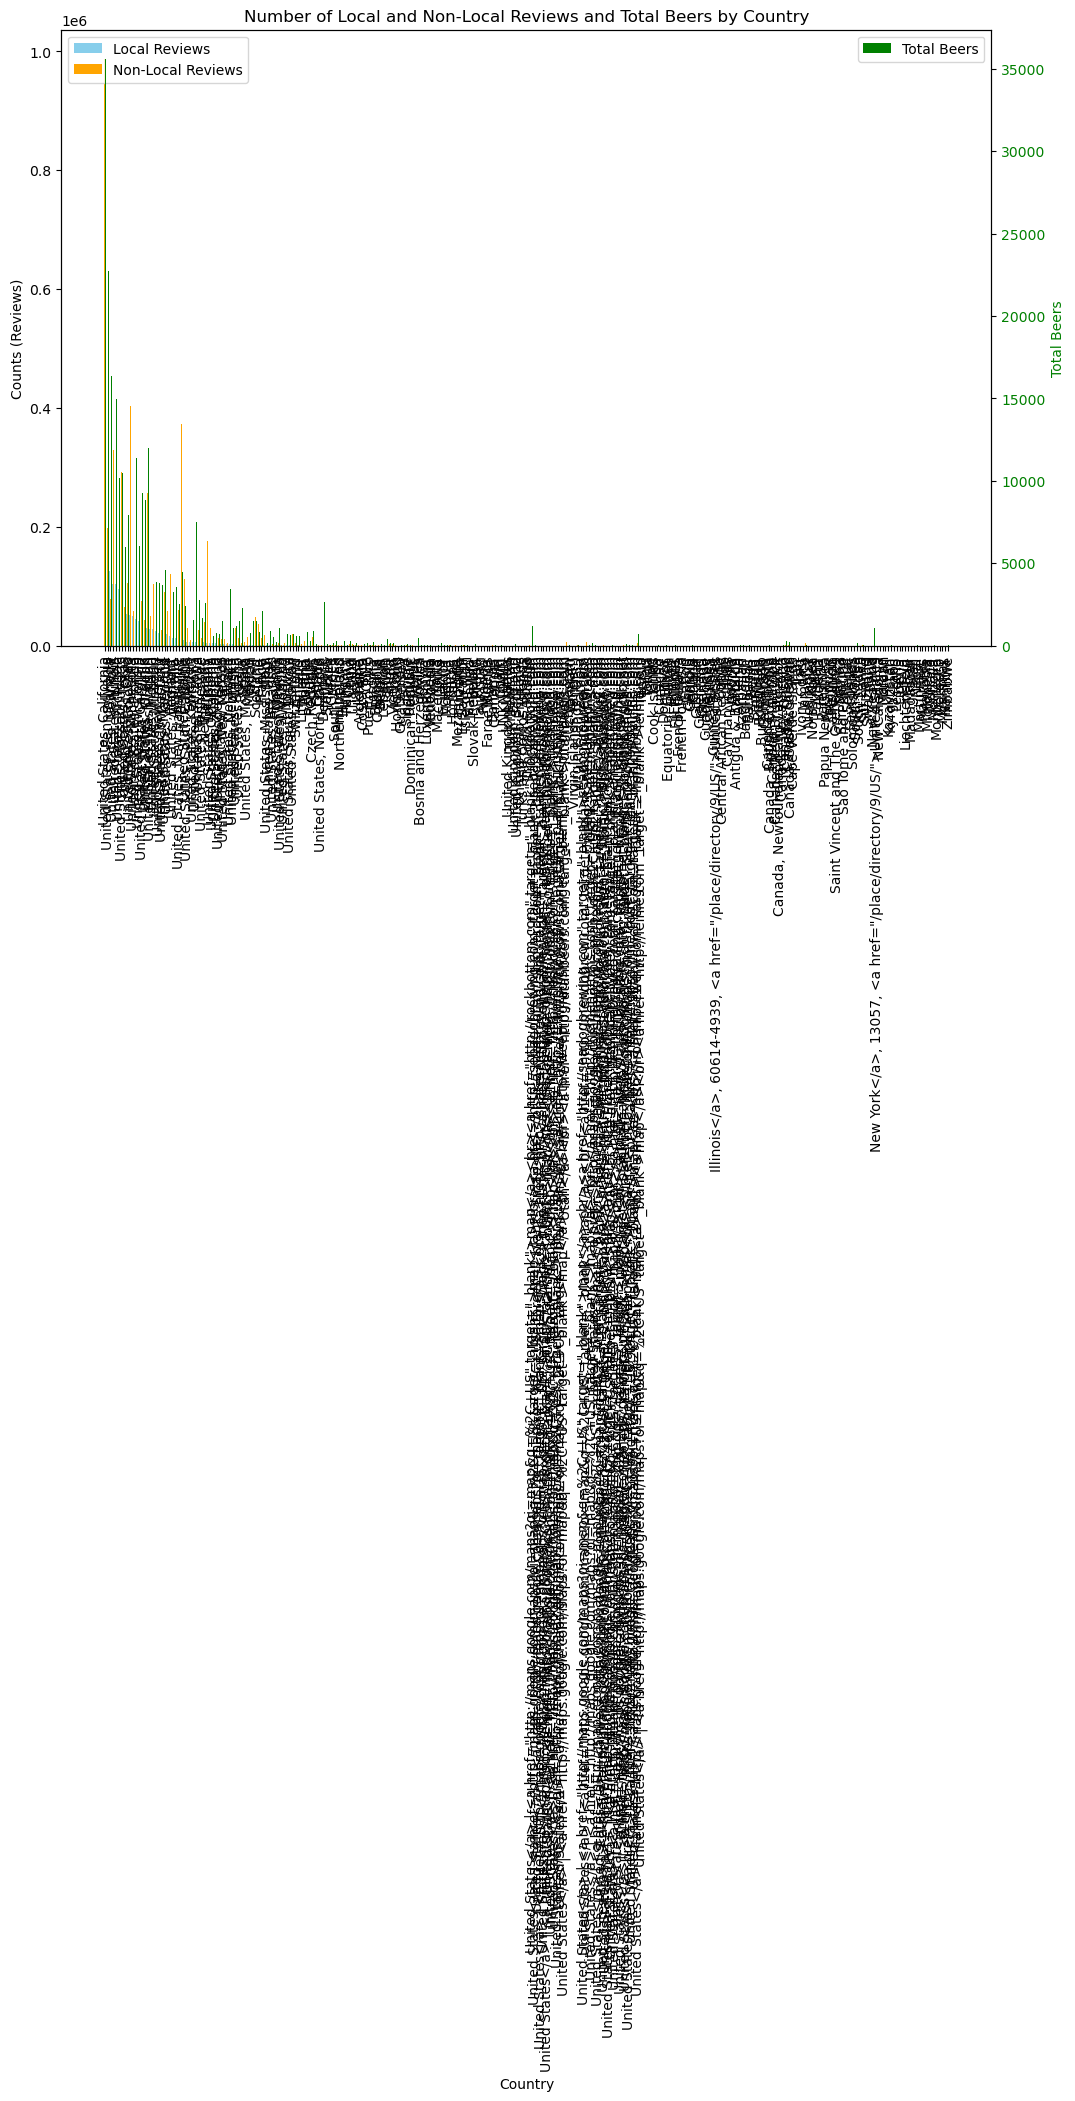

In [ ]:
# Step 1: Remove ratings where user_location is missing (NaN)
BA_merged_cleaned = BA_merged[BA_merged['user_location'].notna()]

# Step 2: Calculate local reviews (reviews written by people from one country reviewing beers from that same country)
local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] == BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='local_reviews')

# Step 3: Calculate non-local reviews (reviews written by people for beers from other countries)
non_local_reviews = BA_merged_cleaned[BA_merged_cleaned['user_location'] != BA_merged_cleaned['beer_location']].groupby('beer_location').size().reset_index(name='non_local_reviews')

# Step 4: Get the total number of beers per country from the 'country_stats' DataFrame
country_stats = breweries.groupby('location').agg(
    total_breweries=('id', 'nunique'),  # Count of unique breweries per country
    total_beers=('nbr_beers', 'sum')  # Sum of beers per country
).reset_index()

# Step 5: Merge the dataframes
country_data = pd.merge(country_stats, local_reviews, left_on='location', right_on='beer_location', how='left')
country_data = pd.merge(country_data, non_local_reviews, left_on='location', right_on='beer_location', how='left')

# Step 6: Fill NaN values with 0 for countries with no reviews in any category
country_data[['local_reviews', 'non_local_reviews']] = country_data[['local_reviews', 'non_local_reviews']].fillna(0)

# Step 7: Sort the DataFrame by the total number of local reviews in ascending order
country_data = country_data.sort_values(by='local_reviews', ascending=False)

# Step 8: Create the figure and the primary axis (for reviews)
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.25
index = range(len(country_data))

# Plot the bars for the 3 different metrics on the primary y-axis
bar1 = ax1.bar(index, country_data['local_reviews'], bar_width, label='Local Reviews', color='skyblue')
bar2 = ax1.bar([i + bar_width for i in index], country_data['non_local_reviews'], bar_width, label='Non-Local Reviews', color='orange')

# Set labels and title for the primary axis
ax1.set_xlabel('Country')
ax1.set_ylabel('Counts (Reviews)', color='black')
ax1.set_title('Number of Local and Non-Local Reviews and Total Beers by Country')

# Set x-ticks and labels
ax1.set_xticks([i + bar_width for i in index])  # Set x-ticks in the center of the 2 bars
ax1.set_xticklabels(country_data['location'], rotation=90)
ax1.tick_params(axis='y', labelcolor='black')

# Step 9: Create the secondary axis (for the total number of beers)
ax2 = ax1.twinx()  # Create a second y-axis
bar3 = ax2.bar([i + 2 * bar_width for i in index], country_data['total_beers'], bar_width, label='Total Beers', color='green')

# Set labels for the secondary axis (right y-axis)
ax2.set_ylabel('Total Beers', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Step 10: Adjust layout and add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Adjust layout for readability
plt.tight_layout()

# Step 11: Show the plot
plt.show()
